# 股票因子提取 - 模型融合GRU、transformer、BN、FC

#目的：使用GRU等多种深度学习模型融合对时间序列股票数据进行特征到收益的预测，并计算返回特征重要性排名，达到挖掘提取有价值的因子的目的，用于收入因子库或进行后期收益预测的权重分配

In [41]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import copy
from sklearn.feature_extraction.text import TfidfVectorizer
plt.rcParams['font.sans-serif']=['SimHei']#画图显示中文字

# 1、数据处理

In [149]:
#数据处理：提取处理特征、标准化、拆分数据集
def dataSet(time_steps=4):
    #读数据
    df = pd.read_csv("data//ch_data.csv",encoding="utf")
    #时间数据转换为时间戳
    df["date"] = df["date"].apply(lambda x:pd.to_datetime(x).value)
    #取特征列
    XAll = df.iloc[:,1:-1]
    #取结果列
    YAll = df.iloc[:,-1:]
    #划分数据集
    X_train,X_test,y_train,y_test = train_test_split(
        XAll,YAll,
        test_size = 0.3,#30%用做测试集
        random_state = 7
    )
    #归一化，标准化
    ssObj = StandardScaler()
    X_train_std = ssObj.fit_transform(X_train)
    X_test_std = ssObj.transform(X_test)#先拆分训练测试集，再标准化，保持真实性
    y_train_std = ssObj.fit_transform(y_train)
    y_test_std = ssObj.transform(y_test)
    
    #按时间序列变形：二维变三维
    #参数：1、训练集数据条数，2、时间步，3、特征数input_size，行列静态二维变为按时间动态交错输入带时序属性的三维，特征数因此打乱自适应）
    X_train_reshape = X_train_std.reshape(X_train_std.shape[0],time_steps,-1)
    X_test_reshape = X_test_std.reshape(X_test_std.shape[0],time_steps,-1)
    #根据模型需要变形Y
    y_train_reshape = y_train_std.reshape(y_train_std.shape[0],-1)#结果列拉平一列，一行数据对应一个结果
    y_test_reshape = y_test_std.reshape(y_test_std.shape[0],-1)
    
    return (X_train_reshape,y_train_reshape,X_test_reshape,y_test_reshape) 
    

# 2、多模型融合搭建GRU+transformer+FC

In [164]:
#建模-多模型融合
class multiModelStock(torch.nn.Module):
    #初始化
    #参数：输入，隐层，输出
    def __init__(self,input_size,hidden_size,output_size,num_layers,num_heads):
        
        super(multiModelStock,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_heads = num_heads
        #定义GRU模型，传入输入特征、隐藏层
        self.gru = torch.nn.GRU(input_size,
                                hidden_size,
                                num_layers)
        #Transformer模型
        self.transformer_encoder_layer= torch.nn.TransformerEncoderLayer(hidden_size,num_heads)
        self.transformer_encoder = torch.nn.TransformerEncoder(self.transformer_encoder_layer,num_layers)#拼合多个EncoderLayer      
        #全连接层
        self.fc = torch.nn.Linear(hidden_size,1)
        
    #前向传播做输入一输出的计算
    def forward(self,x):
        #执行GRU模型
        #GRU的输入x维度(batch_size,time_steps,input_size)，
        #GRU输出结果维度(batch_size,time_steps,hidden_size)#信息压缩提取到隐层
        gru_out,_=self.gru(x)
        #将GRU输出数据做维度变换，以适应transformer的输入
        #transformer所需输入的维度(time_steps,batch_size,hidden_size)#GRU前两维需调换适应
        transformer_input = gru_out.permute(1, 0, 2)#重排调换gru_out前两维顺序
        #执行transformer
        transformer_output1 = self.transformer_encoder(transformer_input)
        #transformer结果维度还原为与GRU维度一致，用于拼接两模型结果，即(batch_size,time_steps,hidden_size)
        #transformer输出维度(time_steps,batch_size,hidden_size)#需将前两维重排调换
        transformer_output = transformer_output1.permute(1,0,2)
        #全连接层
        rs_out = self.fc(transformer_output[:,-1,:])#-1是保留最后一个隐层累计的信息，其余维度保持一致
        #返回结果
        return rs_out

In [165]:
time_steps = 4
#读取数据转为GRU所需的tensor格式
(X_train_reshape,y_train_reshape,X_test_reshape,y_test_reshape) = dataSet(time_steps)

X_train = torch.Tensor(X_train_reshape)
y_train = torch.Tensor(y_train_reshape)
X_test = torch.Tensor(X_test_reshape)
y_test = torch.Tensor(y_test_reshape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([1249, 4, 251])
torch.Size([1249, 1])
torch.Size([536, 4, 251])
torch.Size([536, 1])


In [166]:
#设置超参数
input_size=X_train.shape[2]
hidden_size=64
output_size=1
num_layers =1
num_heads =1
num_epochs = 800#训练多少轮
learning_rate = 0.001
time_steps = 4#数据输入的时间步长切分



#实例化多模型
multiModel = multiModelStock(input_size,hidden_size,output_size,num_layers,num_heads)
#定义学习器
optimizer = torch.optim.Adam(multiModel.parameters(),lr=learning_rate,weight_decay=0.001)
#定义损失函数
criterion = torch.nn.MSELoss()

#用于记录每个epoch的loss值
train_loss=[]

#==训练==
min_loss_val = 10#初始化最小loss
best_model = None#定义初始最好模型
for epoch in range(num_epochs):
    optimizer.zero_grad()#梯度清零
    #调用模型输入数据，计算，前向传播
    output = multiModel(X_train)
    loss = criterion(output,y_train.float())#计算损失
    loss.backward()#反向传播
    optimizer.step()#更新
    
    #存储loss值
    train_loss.append(loss.item())
    
    #打印loss,50个epoch打印一次
    if epoch % 50 == 0:
        print(f"Epoch{epoch}loss：{loss.item()}")
        #最小loss置为最好模型并保存    
        if loss <= min_loss_val:
            min_loss_val = loss
            best_model = copy.deepcopy(multiModel)
            print("save best_model_multi")
            torch.save(best_model.state_dict(),'model//best_model_multi.pth')
multiModel = best_model



Epoch0loss：1.0989282131195068
save best_model_multi
Epoch50loss：0.1635328233242035
save best_model_multi
Epoch100loss：0.03416292741894722
save best_model_multi
Epoch150loss：0.02332965098321438
save best_model_multi
Epoch200loss：0.02002141997218132
save best_model_multi
Epoch250loss：0.019933998584747314
save best_model_multi
Epoch300loss：0.014597643166780472
save best_model_multi
Epoch350loss：0.01167159155011177
save best_model_multi
Epoch400loss：0.01012149266898632
save best_model_multi
Epoch450loss：0.022463230416178703
Epoch500loss：0.010387685149908066
Epoch550loss：0.008728936314582825
save best_model_multi
Epoch600loss：0.009107884019613266
Epoch650loss：0.009205327369272709
Epoch700loss：0.00910781230777502
Epoch750loss：0.009587086737155914


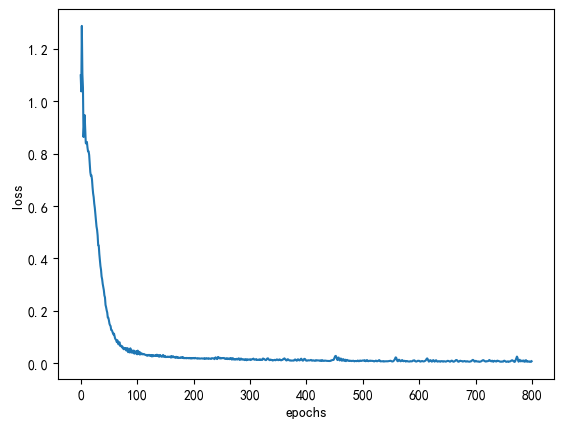

In [167]:
#画图
f1 = plt.figure()
plt.plot(range(len(train_loss)),train_loss)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig("loss_multi.png")
plt.show()

In [168]:
#预测
y_pred = multiModel(X_test)
y_pred_rs = y_pred.detach().numpy()#将张量分离并转换为NumPy数组
y_test_rs = y_test.detach().numpy()

C:\Users\A\AppData\Local\Temp\ipykernel_9552\2653572566.py:8: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig("testMultiModel.png")
C:\Users\A\.conda\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


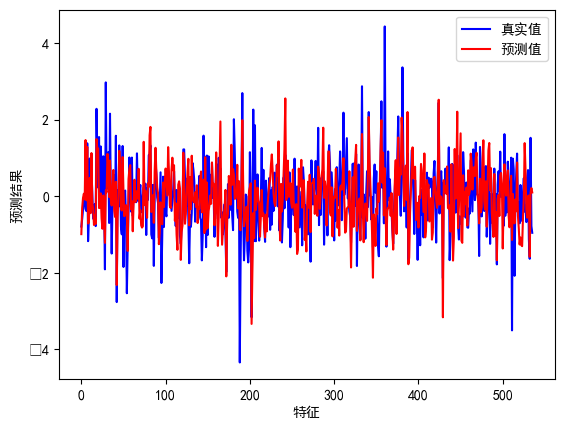

In [169]:
#画图
f2=plt.figure()
plt.plot(y_test_rs,color="blue",label="真实值")
plt.plot(y_pred_rs,color="red",label="预测值")
plt.legend()
plt.xlabel("特征")
plt.ylabel("预测结果")
plt.savefig("testMultiModel.png")
plt.show()

In [170]:
#模型评估
test_rmse = np.sqrt(np.mean(np.square(y_pred_rs,y_test_rs)))
test_mae = np.mean(np.abs(y_pred_rs,y_test_rs))
print("test_rmse:",test_rmse,"\n","test_mae:",test_mae)

test_rmse: 0.7957927 
 test_mae: 0.61610264


加CRU+transformer在测试集效果好于单独一个GRU,SE-GRU比它略强，训练集loss收敛线较平滑

# 3、多模型融合搭建GRU+transformer+BN+FC

In [178]:
time_steps = 4
#读取数据转为GRU所需的tensor格式
(X_train_reshape,y_train_reshape,X_test_reshape,y_test_reshape) = dataSet(time_steps)

X_train = torch.Tensor(X_train_reshape)
y_train = torch.Tensor(y_train_reshape)
X_test = torch.Tensor(X_test_reshape)
y_test = torch.Tensor(y_test_reshape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([1249, 4, 251])
torch.Size([1249, 1])
torch.Size([536, 4, 251])
torch.Size([536, 1])


In [196]:
#建模-多模型融合
class multiModelStock2(torch.nn.Module):
    #初始化
    #参数：输入，隐层，输出
    def __init__(self,input_size,hidden_size,output_size,num_layers,num_heads):
        
        super(multiModelStock2,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_heads = num_heads
        #GRU模型
        self.gru = torch.nn.GRU(input_size,
                                hidden_size,
                                num_layers)
        #Transformer模型
        self.transformer_encoder_layer= torch.nn.TransformerEncoderLayer(hidden_size,num_heads)
        self.transformer_encoder = torch.nn.TransformerEncoder(self.transformer_encoder_layer,num_layers)#拼合多个EncoderLayer      
        
        #BN层
        self.bn = torch.nn.BatchNorm1d(hidden_size)
        
        #全连接层
        self.fc = torch.nn.Linear(hidden_size,1)
        
    #前向传播做输入一输出的计算
    def forward(self,x):
        #运行GRU模型
        #GRU的输入x维度(batch_size,time_steps,input_size)，
        #GRU输出结果维度(batch_size,time_steps,hidden_size)#信息压缩提取到隐层
        gru_out,_=self.gru(x)
        
        #运行transformer
        #将GRU输出数据做维度变换，以适应transformer的输入
        #transformer所需输入的维度(time_steps,batch_size,hidden_size)#GRU前两维需调换适应
        transformer_input = gru_out.permute(1, 0, 2)#重排调换gru_out前两维顺序
        transformer_output1 = self.transformer_encoder(transformer_input)
        #transformer结果维度还原为与GRU维度一致，用于拼接两模型结果，即(batch_size,time_steps,hidden_size)
        #transformer输出维度(time_steps,batch_size,hidden_size)#需将前两维重排调换
        transformer_output = transformer_output1.permute(1,0,2)
        
        #运行BN层
        #transformer输出变形符合BN输入要求
        bn_input = transformer_output.reshape(-1, transformer_output.shape[-1])
        bn_out = self.bn(bn_input)

        #全连接层
        fc_out = self.fc(bn_out)#时间步位置维度-1是保留最后一个隐层累计的信息，其余维度保持一致)
        #维度还原
        rs_out = fc_out.reshape(transformer_output.shape[0],transformer_output.shape[1],-1) #变为[batch_size, seq_len, num_classes]
        #返回结果
        return rs_out[:,-1,:]#-1是时间步维度位置保留最后一个隐层累计的信息，其余维度保持一致

In [197]:
#设置超参数
input_size=X_train.shape[2]
hidden_size=64
output_size=1
num_layers =1
num_heads =1
num_epochs = 800#训练多少轮
learning_rate = 0.001
time_steps = 4#数据输入的时间步长切分



#实例化多模型
multiModel2 = multiModelStock2(input_size,hidden_size,output_size,num_layers,num_heads)
#定义学习器
optimizer = torch.optim.Adam(multiModel2.parameters(),lr=learning_rate,weight_decay=0.001)
#定义损失函数
criterion = torch.nn.MSELoss()

#用于记录每个epoch的loss值
train_loss=[]

#==训练==
min_loss_val = 10#初始化最小loss
best_model = None#定义初始最好模型
for epoch in range(num_epochs):
    optimizer.zero_grad()#梯度清零
    #调用模型输入数据，计算，前向传播
    output = multiModel2(X_train)
    loss = criterion(output,y_train.float())#计算损失
    loss.backward()#反向传播
    optimizer.step()#更新
    
    #存储loss值
    train_loss.append(loss.item())
    
    #打印loss,50个epoch打印一次
    if epoch % 50 == 0:
        print(f"Epoch{epoch}loss：{loss.item()}")
        #最小loss置为最好模型并保存    
        if loss <= min_loss_val:
            min_loss_val = loss
            best_model = copy.deepcopy(multiModel2)
            print("save best_model_multi2")
            torch.save(best_model.state_dict(),'model//best_model_multi2.pth')
multiModel2 = best_model



Epoch0loss：1.3758577108383179
save best_model_multi2
Epoch50loss：0.10516853630542755
save best_model_multi2
Epoch100loss：0.03170251473784447
save best_model_multi2
Epoch150loss：0.02208017371594906
save best_model_multi2
Epoch200loss：0.020430555567145348
save best_model_multi2
Epoch250loss：0.018710432574152946
save best_model_multi2
Epoch300loss：0.015148883685469627
save best_model_multi2
Epoch350loss：0.013956946320831776
save best_model_multi2
Epoch400loss：0.01061256043612957
save best_model_multi2
Epoch450loss：0.01352716889232397
Epoch500loss：0.012742980383336544
Epoch550loss：0.00799779873341322
save best_model_multi2
Epoch600loss：0.008014241233468056
Epoch650loss：0.007275817450135946
save best_model_multi2
Epoch700loss：0.008530206978321075
Epoch750loss：0.006736220791935921
save best_model_multi2


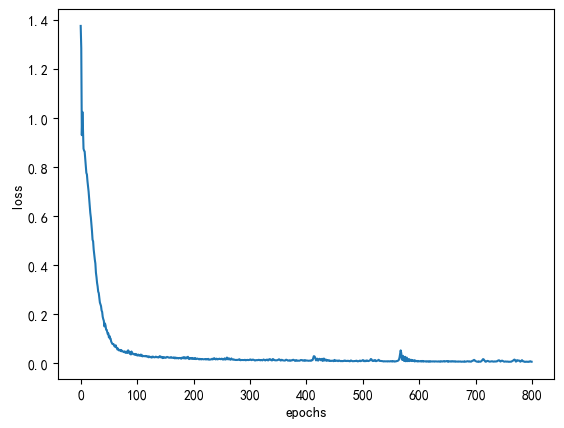

In [199]:
#画图
f1 = plt.figure()
plt.plot(range(len(train_loss)),train_loss)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig("loss_multi2.png")
plt.show()

In [200]:
#预测
y_pred = multiModel2(X_test)
y_pred_rs = y_pred.detach().numpy()#将张量分离并转换为NumPy数组
y_test_rs = y_test.detach().numpy()

C:\Users\A\AppData\Local\Temp\ipykernel_9552\3948641260.py:8: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig("testMultiModel2.png")
C:\Users\A\.conda\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


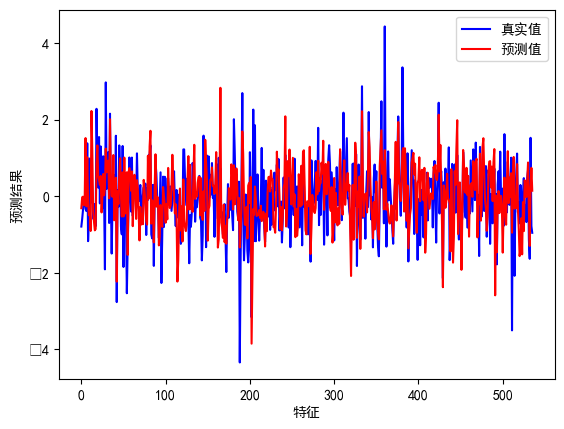

In [201]:
#画图
f2=plt.figure()
plt.plot(y_test_rs,color="blue",label="真实值")
plt.plot(y_pred_rs,color="red",label="预测值")
plt.legend()
plt.xlabel("特征")
plt.ylabel("预测结果")
plt.savefig("testMultiModel2.png")
plt.show()

In [202]:
#模型评估
test_rmse = np.sqrt(np.mean(np.square(y_pred_rs,y_test_rs)))
test_mae = np.mean(np.abs(y_pred_rs,y_test_rs))
print("test_rmse:",test_rmse,"\n","test_mae:",test_mae)

test_rmse: 0.800536 
 test_mae: 0.6250378


本例中GRU+transformer+fc模型融合基本上加入了BN模型在测试集表现比之前略有提升  
rmse提升1%  
mae提升1%

# 4、计算特征重要性

# 目的：通过特征重要性排序筛选因子，入库，或用于后续模型搭建  
#思路：遍历每个特征训练记录Loss，返回排序，loss低的重要  


In [204]:
def featuresImportance():
    #设置超参数
    input_size=X_train.shape[2]
    hidden_size=64
    output_size=1
    num_layers =1
    num_heads =1
    num_epochs = 800#训练多少轮
    learning_rate = 0.001
    time_steps = 4#数据输入的时间步长切分



    #实例化多模型
    multiModel3 = multiModelStock2(input_size,hidden_size,output_size,num_layers,num_heads)
    #定义学习器
    optimizer = torch.optim.Adam(multiModel3.parameters(),lr=learning_rate,weight_decay=0.001)
    #定义损失函数
    criterion = torch.nn.MSELoss()

    #用于记录每个epoch的loss值
    train_loss=[]
    feature_losses_list = []#用于存放每个特征的loss
    #==训练==
    min_loss_val = 10#初始化最小loss
    best_model = None#定义初始最好模型
    for epoch in range(num_epochs):
        featuresLoss = 0#记录特征loss累计值
        for i in range(input_size):
            xi = X_train.clone()
            xi[:,:,i]=0#【将第i个特征设为0，其他不变，来看它不存在时loss的情况，以此判断影响力】
            optimizer.zero_grad()#梯度清零
            #调用模型输入数据，计算，前向传播
            output = multiModel3(X_train)
            loss = criterion(output,y_train.float())#计算损失
            loss.backward()#反向传播
            optimizer.step()#更新
            featuresLoss += loss.item()
            feature_losses_list.append(loss.item())

        #存储l本轮oss值
        train_loss.append(loss.item())
        
        #打印loss,50个epoch打印一次
        if epoch % 50 == 0:
            print(f"Epoch-{epoch}loss：{loss.item()}，特征重要性loss记录：{featuresLoss/input_size}")
            #最小loss置为最好模型并保存    
            if loss <= min_loss_val:
                min_loss_val = loss
                best_model = copy.deepcopy(multiModel3)
                print("save best_model_multi3")
                torch.save(best_model.state_dict(),'model//best_model_multi3.pth')
    multiModel3 = best_model
    
    #计算特征重要性
    losses_np = np.array(feature_losses_list)
    base_loss = losses_np[-1]
    importances = base_loss - losses_np[:-1]
    
    return importances

In [ ]:
featuresImportance()

本例中使用数据有1000多特征列，采用上面方法遍历每个特征计算loss的方式效率缓慢，改进方向有下面几种  
1、GRU前加SE降维，或加GBDT、决策树、XGBoost等先进行一步特征选择，再进行训练  
2、采用分布式多线程或GPU运算  
3、将数据集封装成Dataset,DataLoader加载数据分批次运算以及调整bacth epoch 学习率等  
4、采用其它特征重要性工具如lime等  

5、因子分析挖掘模型融合方面改进可以补充多数据源，多组模型再次融合concat